## STEP.6 
Enter coordinates (longitude, latitude, elevation) to find the nearest 5 stations

In [31]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np

# Load data from CSV
def load_site_data(filepath):
    df = pd.read_csv(filepath)
    # Ensure latitude, longitude, and elevation are float
    df['LATITUDE'] = df['LATITUDE'].astype(float)
    df['LONGITUDE'] = df['LONGITUDE'].astype(float)
    df['ELEVATION'] = df['ELEVATION'].astype(float)
    return df

# Function to calculate three-dimensional distance
def calculate_3d_distance(lat1, lon1, ele1, lat2, lon2, ele2):
    # Calculate horizontal distance (in kilometers)
    horizontal_distance = geodesic((lat1, lon1), (lat2, lon2)).kilometers
    # Calculate elevation difference (in meters)
    elevation_diff = ele2 - ele1
    # Convert elevation difference from meters to kilometers
    elevation_diff_km = elevation_diff / 1000
    # Calculate three-dimensional distance
    distance_3d = np.sqrt(horizontal_distance**2 + elevation_diff_km**2)
    return distance_3d

# Find the nearest sites based on 3D distance
def find_nearest_sites(df, target_location, target_elevation, top_n=5):
    # Calculate 3D distances to all sites
    df['THREE_DIMENSIONAL_DISTANCE'] = df.apply(
        lambda row: calculate_3d_distance(
            target_location[0], target_location[1], target_elevation,
            row['LATITUDE'], row['LONGITUDE'], row['ELEVATION']
        ), axis=1
    )
    # Sort by 3D distance and select the top_n sites
    nearest_sites = df.sort_values('THREE_DIMENSIONAL_DISTANCE').head(top_n)
    return nearest_sites[['STATION_ID', 'STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'THREE_DIMENSIONAL_DISTANCE']]

# Load site data
df_sites = load_site_data('/Users/a1234/Desktop/workspace/777/GDAL/data/jp.csv')

# Target location (latitude, longitude) and elevation (in meters)
target_location = (35.6895, 98.6917)  # Tokyo's latitude and longitude
target_elevation = 40.0  # Assumed elevation for Tokyo in meters

# Find the nearest sites
nearest_sites_df = find_nearest_sites(df_sites, target_location, target_elevation)

# Convert nearest site IDs to a list of strings with the first five characters
nearest_ids = [str(id)[:5] for id in nearest_sites_df['STATION_ID'].tolist()]
print(nearest_ids)


['47843', '47844', '47811', '47812', '47811']


Epoch 1/20
5426/5426 ━━━━━━━━━━━━━━━━━━━━ 3s 455us/step - loss: 0.1654 - val_loss: 0.0729
Epoch 2/20
5426/5426 ━━━━━━━━━━━━━━━━━━━━ 2s 423us/step - loss: 0.0682 - val_loss: 0.0629
Epoch 3/20
5426/5426 ━━━━━━━━━━━━━━━━━━━━ 2s 424us/step - loss: 0.0626 - val_loss: 0.0610
Epoch 4/20
5426/5426 ━━━━━━━━━━━━━━━━━━━━ 2s 433us/step - loss: 0.0602 - val_loss: 0.0606
Epoch 5/20
5426/5426 ━━━━━━━━━━━━━━━━━━━━ 2s 445us/step - loss: 0.0590 - val_loss: 0.0594
Epoch 6/20
5426/5426 ━━━━━━━━━━━━━━━━━━━━ 2s 428us/step - loss: 0.0579 - val_loss: 0.0582
Epoch 7/20
5426/5426 ━━━━━━━━━━━━━━━━━━━━ 2s 430us/step - loss: 0.0567 - val_loss: 0.0569
Epoch 8/20
5426/5426 ━━━━━━━━━━━━━━━━━━━━ 2s 440us/step - loss: 0.0564 - val_loss: 0.0565
Epoch 9/20
5426/5426 ━━━━━━━━━━━━━━━━━━━━ 2s 445us/step - loss: 0.0560 - val_loss: 0.0557
Epoch 10/20
5426/5426 ━━━━━━━━━━━━━━━━━━━━ 2s 425us/step - loss: 0.0552 - val_loss: 0.0559
Epoch 11/20
5426/5426 ━━━━━━━━━━━━━━━━━━━━ 2s 423us/step - loss: 0.0549 - val_loss: 0.0554
Epoch 12

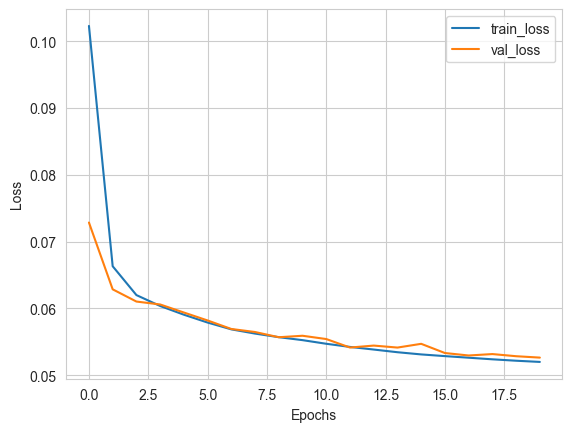

1696/1696 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


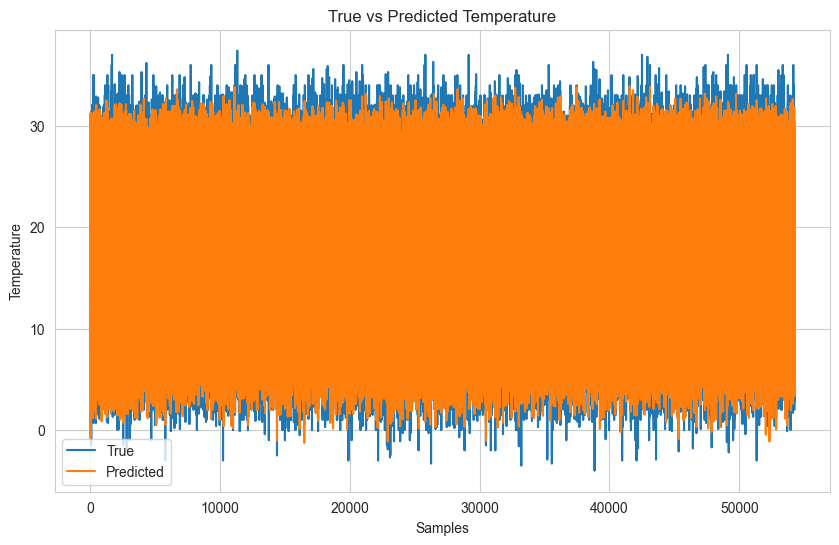

Mean Squared Error (MSE): 3.178171596667117
Mean Absolute Error (MAE): 1.3668709577315874
R^2 Score: 0.947161064499021
Total runtime: 50.61222004890442 seconds


In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, when
from pyspark.sql.types import StructType, StructField, StringType, FloatType
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt
import time
import os
import json

def prepare_data(spark, conjson_dir, target_column, site_ids):
    all_data = []
    for filename in os.listdir(conjson_dir):
        if filename.startswith('4') and any(str(site_id) in filename for site_id in site_ids):
            file_path = os.path.join(conjson_dir, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)
                all_data.extend(data)

    if not all_data:
        raise ValueError("No data found.")

    # Create a generic schema with all fields as StringType
    schema = StructType([StructField(field, StringType(), nullable=True) for field in all_data[0].keys()])

    # Create DataFrame
    df = spark.createDataFrame(all_data, schema=schema)

    # Convert columns to appropriate data types
    for field in df.schema.fields:
        column_name = field.name
        if column_name in [target_column, 'DewPointTemperature', 'Pressure', 'WindDirection', 'WindSpeed']:
            df = df.withColumn(column_name, col(column_name).cast(FloatType()))

    # Drop rows with missing target values
    df = df.na.drop(subset=[target_column])
    
    # Handling NaN values for 'CloudCover', 'Rain1h', 'Rain6h'
    fill_values = {
        'CloudCover': 0,  # Or another placeholder value or the column's mean/median
        'Rain1h': 0,      # Or another placeholder value or the column's mean/median
        'Rain6h': 0       # Or another placeholder value or the column's mean/median
    }
    df = df.fillna(fill_values)

    return df

def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(50, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

if __name__ == "__main__":
    # Initialize Spark session
    spark = SparkSession.builder \
        .appName("TemperaturePredictionWithSpark") \
        .getOrCreate()

    # Set directory and target column
    base_directory = '/Users/a1234/Desktop/workspace/777/GDAL/noaa_data/2014_2024_jp/conjson'
    target_column = 'Temperature'
    #nearest_ids = [1, 2, 3]  # Example nearest_ids list

    # Record the start time
    start_time = time.time()

    # Prepare data
    df = prepare_data(spark, base_directory, target_column, nearest_ids)
    print(df.describe())
    print(df)

    # Separate feature columns and target column
    feature_columns = [col for col in df.columns if col != target_column]
    X = df.select(feature_columns).toPandas().values
    y = df.select(target_column).toPandas().values

    # Standardize the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    

    # Build the LSTM model
    model = build_model((1, X_train.shape[2]))
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)

    # Evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f'Model Test Loss: {loss}')

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Visualize predicted results
    y_pred = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test = scaler_y.inverse_transform(y_test)
    
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Samples')
    plt.ylabel('Temperature')
    plt.title('True vs Predicted Temperature')
    plt.legend()
    plt.show()

    # Calculate additional evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')

    # Record the end time
    end_time = time.time()
    # Calculate and print the runtime
    runtime = end_time - start_time
    print("=======================================================")
    print(f"Total runtime: {runtime} seconds")
    print("=======================================================")

    # Stop Spark session
    spark.stop()


## STEP.9 Spark Optimization Technology
### 9.1 *Memory and core management* 
This script calculates and estimates the amount of memory and CPU cores needed to process data within a specified directory using Apache Spark. It's tailored for situations where data processing requirements depend on the total size of the data.  

In [29]:
# Import the os module to interact with the operating system
import os

# Define a function to estimate the resources required by Apache Spark based on the data size
def estimate_spark_resources(data_dir):
    # Calculate the total data size by summing the size of each file in the directory
    total_data_size = sum(os.path.getsize(os.path.join(data_dir, f)) for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f)))

    # Define the amount of memory (in GB) required per GB of data
    memory_per_gb_data = 4  # Adjust as needed based on application requirements
    # Define the number of cores required per GB of data
    cores_per_gb_data = 0.5  # Adjust as needed based on application requirements

    # Calculate the total memory required by converting the total data size from bytes to GB and multiplying by the memory ratio
    total_memory = total_data_size / (1024**3) * memory_per_gb_data
    # Calculate the total number of cores required in a similar manner
    total_cores = total_data_size / (1024**3) * cores_per_gb_data
    # Return the total memory and cores calculated
    return total_memory, total_cores

# The main entry point for the script
if __name__ == "__main__":
    # Specify the directory containing the data
    conjson_dir = '/Users/a1234/Desktop/workspace/777/GDAL/noaa_data1/2014_2024_jp/cleaned'
    
    # Estimate the required resources (memory and cores) for the data in the specified directory
    required_memory, required_cores = estimate_spark_resources(conjson_dir)
    # Print the estimated resources for Spark executors, dividing the total resources by 2 assuming a distribution strategy
    print(f"Estimated spark.executor.memory: {required_memory}g")  # Print the estimated memory in gigabytes
    print(f"Estimated spark.executor.cores: {required_cores}")  # Print the estimated number of cores


Estimated spark.executor.memory: 16.93175894021988g
Estimated spark.executor.cores: 2.116469867527485


### 9.2 *Caching or Persistence:* 
Use cache() or persist() on frequently queried data to avoid double counting.
### 9.3 *Broadcast variables:* 
Use broadcast variables to minimize data transfers when large amounts of data need to be shared across multiple nodes.

**DATA: Hourly weather data from 2014 to 2024 for about 200 stations throughout Japan, totaling 9.16 GB.**

Epoch 1/20
265170/265170 ━━━━━━━━━━━━━━━━━━━━ 117s 440us/step - loss: 0.1081 - val_loss: 0.0980
Epoch 2/20
265170/265170 ━━━━━━━━━━━━━━━━━━━━ 118s 445us/step - loss: 0.0974 - val_loss: 0.0966
Epoch 3/20
265170/265170 ━━━━━━━━━━━━━━━━━━━━ 121s 457us/step - loss: 0.0963 - val_loss: 0.0958
Epoch 4/20
265170/265170 ━━━━━━━━━━━━━━━━━━━━ 125s 473us/step - loss: 0.0958 - val_loss: 0.0953
Epoch 5/20
265170/265170 ━━━━━━━━━━━━━━━━━━━━ 122s 460us/step - loss: 0.0953 - val_loss: 0.0951
Epoch 6/20
265170/265170 ━━━━━━━━━━━━━━━━━━━━ 122s 461us/step - loss: 0.0950 - val_loss: 0.0950
Epoch 7/20
265170/265170 ━━━━━━━━━━━━━━━━━━━━ 122s 461us/step - loss: 0.0947 - val_loss: 0.0948
Epoch 8/20
265170/265170 ━━━━━━━━━━━━━━━━━━━━ 123s 462us/step - loss: 0.0947 - val_loss: 0.0948
Epoch 9/20
265170/265170 ━━━━━━━━━━━━━━━━━━━━ 123s 463us/step - loss: 0.0945 - val_loss: 0.0946
Epoch 10/20
265170/265170 ━━━━━━━━━━━━━━━━━━━━ 133s 500us/step - loss: 0.0943 - val_loss: 0.0944
Epoch 11/20
265170/265170 ━━━━━━━━━━━━━

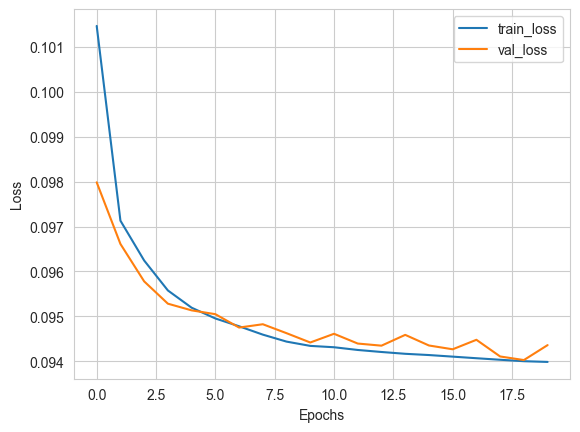

82866/82866 ━━━━━━━━━━━━━━━━━━━━ 18s 216us/step


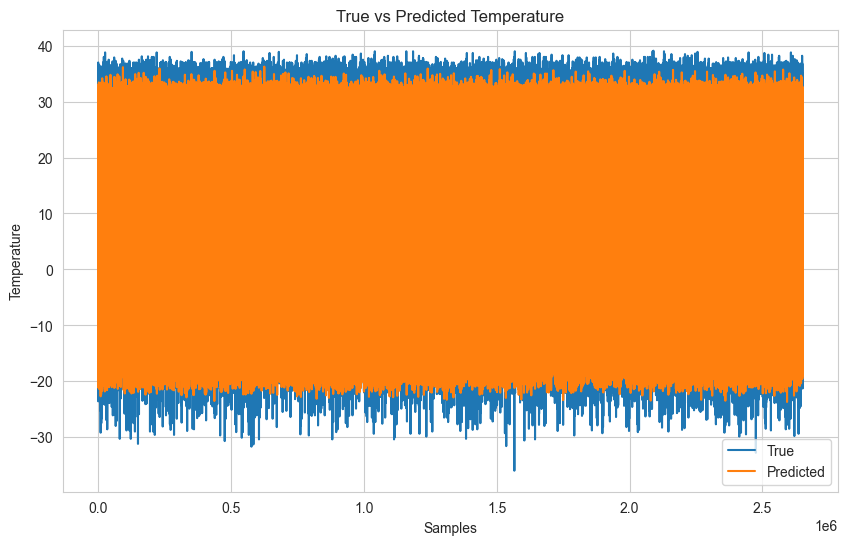

Mean Squared Error (MSE): 8.81218209627953
Mean Absolute Error (MAE): 2.260263417875243
R^2 Score: 0.9054398497907826
Total runtime: 2492.953243970871 seconds


In [33]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.storagelevel import StorageLevel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import json
import time

# Initialize Spark session
def initialize_spark_session(): #******
    spark = SparkSession.builder \
        .appName("TemperaturePredictionWithSpark") \
        .config("spark.executor.memory", "16g") \ 
        .config("spark.executor.cores", "2") \
        .getOrCreate()
    return spark

# Load and prepare data
def load_and_prepare_data(spark, conjson_dir, target_column, site_ids):
    all_data = []
    for filename in os.listdir(conjson_dir):
        if filename.startswith('4') and any(str(site_id) in filename for site_id in site_ids):
            file_path = os.path.join(conjson_dir, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)
                all_data.extend(data)

    schema = StructType([
        StructField('Year', IntegerType(), True),
        StructField('Month', IntegerType(), True),
        StructField('Day', IntegerType(), True),
        StructField('Hour', IntegerType(), True),
        StructField('Temperature', FloatType(), True),
        StructField('DewPointTemperature', FloatType(), True),
        StructField('Pressure', FloatType(), True),
        StructField('WindDirection', FloatType(), True),
        StructField('WindSpeed', FloatType(), True),
        StructField('CloudCover', IntegerType(), True),
        StructField('Rain1h', FloatType(), True),
        StructField('Rain6h', FloatType(), True)
    ])

    df = spark.createDataFrame(data=all_data, schema=schema)

    # Cache the DataFrame to optimize performance
    df.cache() #******

    feature_columns = [field.name for field in schema.fields if field.name != target_column]
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

    pipeline = Pipeline(stages=[assembler, scaler])
    pipelineModel = pipeline.fit(df)
    processed_df = pipelineModel.transform(df)

    # Persist the processed DataFrame in memory and disk for further optimization
    processed_df.persist(StorageLevel.MEMORY_AND_DISK)  #******

    return processed_df

# Build and train LSTM model
def build_and_train_model(processed_df, target_column):
    pd_df = processed_df.select("scaledFeatures", target_column).toPandas()
    X = np.array(pd_df["scaledFeatures"].tolist())
    y = pd_df[target_column].values.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    model = Sequential([
        Input(shape=(1, X_train.shape[2])),
        LSTM(50, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)

    return model, X_test, y_test, history

if __name__ == "__main__":
    conjson_dir = '/Users/a1234/Desktop/workspace/777/GDAL/noaa_data/2014_2024_jp/conjson'
    target_column = 'Temperature'
    site_ids = nearest_ids  # Assuming nearest_ids is defined somewhere else
    start_time = time.time()

    # Load and preprocess data
    processed_df = load_and_prepare_data(spark, conjson_dir, target_column, site_ids)

    # Convert to Pandas DataFrame for model training
    pd_df = processed_df.select("scaledFeatures", target_column).toPandas()
    X = np.array(pd_df["scaledFeatures"].tolist())
    y = pd_df[target_column].values

    # Split dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build and train the model
    model = build_and_train_model(processed_df, target_column)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')

    # Record the end time
    end_time = time.time()
    # Calculate and print the runtime
    runtime = end_time - start_time
    print("=======================================================")
    print(f"Total runtime: {runtime} seconds")
    print("=======================================================")

    # Stop Spark session
    spark.stop()
